#DATASCI W261: Machine Learning at Scale
## HW6.6

**Angela Gunn &  Jing Xu **  
**angela@egunn.com **  
**jaling@gmail.com **  

**MIDS - W261 - Section 3**  
**February 24, 2016**  
**Assignment : Week 6**


#Introduction
This is a map-reduce version of expectation maximization algo for a mixture of Gaussians model. There are two mrJob MR packages, mr_GMixEmIterate and mr_GMixEmInitialize. The driver calls the mrJob packages and manages the iteration.

The multivariate Gaussian probability density function is defined as follows:

Equation 1: $$\mathcal{N}(x|\mu,\Sigma) = \frac{1}{(2\pi)^{\frac{1}{2}}|\Sigma|^{\frac{1}{2}}}exp\left ( -\frac{1}{2}(x-\mu)^T \Sigma^{-1}(x-\mu) \right )$$

#Expectation Step: 
Given priors, mean vector and covariance matrix, calculate the probability of that each data point belongs to a class

$\omega_k^i = p(w_k | x^i,\theta) =  \frac{\pi_k  \mathcal{N} (x^i | \mu_k,\sum_k)}{\sum_{j=1}^K \mathcal{N}(x^i | \mu_k,\sum_k)} \Rightarrow  $ equation <b>1</b>

where 

* k = number of classes 
* i = example index
* $\theta$ = (phi, mu, sigma)
* $\mu$ = centroid 
* $\Sigma$ = covariance matrix
* $\mathcal{N}$ = number of samples
* $\pi$ = prior class probability

$\mathcal{N}(x^i | \mu_k,\sum_k) $ is calculated as below 



$p(x; \mu, \sum) = \frac{1}{(2\pi)^{n/2}\left | \sum \right |^{1/2}} exp  (-\frac{1}{2} (x-\mu)^{T} \sum^{-1} (x-\mu)  ) \Rightarrow $ equation <b>2</b>  



Where $ \left | \sum \right |$ is the determinant of corvariance matrix

#M Step: 
$Centroid_k \Rightarrow  \hat{\mu_k} =  \frac {1}{n_k} \sum_{i=1}^n p(w_k | x_i, \theta)x^i $

which is calculated as  

$ Centroid_k \Rightarrow  \mu_k = \frac{ \sum_{i=1}^{n} \omega_k^i x^i }{\sum_{i=1}^{m} \omega_k^i } \Rightarrow$ equation <b>3</b>

<br></br>

$Covariance_k \Rightarrow \hat{\sum_k} =  \frac {1}{n_k} \sum_{i=1}^n p(w_k | x_i, \theta) (x^i -\hat{\mu_k}) (x^i -\hat{\mu_k})^T $

which is calculated as 

$Covariance_k \Rightarrow \sum_k = \frac{ \sum_{i=1}^{n} \omega_k^i (x^i-\mu_k)(x^i-\mu)^T} {\sum_{i=1}^{m} \omega_k^i}\Rightarrow$ equation <b>4</b>

<br></br>

$Prior_k \Rightarrow \hat{\pi_k} =  \frac {n_k}{n} $where $ n_k =  \sum_{i=1}^n p(w_k | x_i, \theta)  $

which is calculated as 

$Prior \Rightarrow \phi_k = \frac{1}{n} \sum_{i=1}^{n} \omega_k^i  \Rightarrow$ equation <b>5</b>


#Data Generation


In [3]:
 %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import json
size1 = size2 = size3 = 1000  #set size 1000

#generate random arrays for our clusters; append to data
samples1 = np.random.multivariate_normal([4, 0], [[1, 0],[0, 1]], size1)
data = samples1
samples2 = np.random.multivariate_normal([6, 6], [[1, 0],[0, 1]], size2)
data = np.append(data,samples2, axis=0)
samples3 = np.random.multivariate_normal([0, 4], [[1, 0],[0, 1]], size3)
data = np.append(data,samples3, axis=0)

# Randomlize data
data = data[np.random.permutation(size1+size2+size3),]
with open("data.txt", "w") as f:
    for row in data.tolist():
        json.dump(row, f)
        f.write("\n")

#Data Visualization

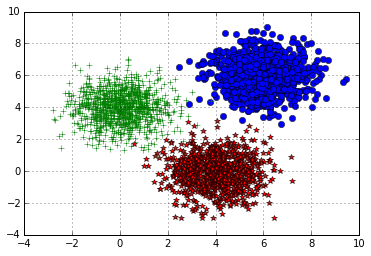

In [5]:
#plot
plt.plot(samples1[:, 0], samples1[:, 1],'*', color = 'red' )
plt.plot(samples2[:, 0], samples2[:, 1],'o',color = 'blue')
plt.plot(samples3[:, 0], samples3[:, 1],'+',color = 'green')


plt.grid(True)
plt.show()

#Initialization
Here suppose we know there are 3 components

In [7]:
%%writefile mr_GMM_Init.py
from mrjob.job import MRJob
from mrjob.step import MRStep

from numpy import mat, zeros, shape, random, array, zeros_like, dot, linalg
from random import sample
import json
from math import pi, sqrt, exp, pow


class GMM_Init(MRJob):
    DEFAULT_PROTOCOL = 'json'
    
    def steps(self):
        return [
                MRStep(mapper=self.mapper,
                       reducer=self.reducer)
            ]

    
    def __init__(self, *args, **kwargs):
        #call base init method
        super(GMM_Init, self).__init__(*args, **kwargs)
        
        self.numMappers = 1     #number of mappers
        self.count = 0
        
                                                 
    def configure_options(self):
        #call base configure_options method
        super(GMM_Init, self).configure_options()
        
        self.add_passthrough_option(
            '--k', dest='k', default=3, type='int',
            help='k: number of densities in mixture')
        self.add_passthrough_option(
            '--pathName', dest='pathName', default="", type='str',
            help='pathName: pathname where intermediateResults.txt is stored')
        
    def mapper(self, key, values):
        #something simple to grab random starting point
        #collect the first 2k  points (this isn't 2000, this is 2*the number of densities)
        #The values are points
        if self.count <= 2*self.options.k:
            self.count += 1
            yield (1,values)        
        
    def reducer(self, key, values):        
        #receives an integer as the key, and a data point as the values.
        
        #accumulate data points mapped to 0 from 1st mapper and pull out k of them as starting point
        centroids = []
        
        #load the values and append to centroids; then emit 1, and the value
        for xj in values:
            x = json.loads(xj)
            centroids.append(x)
            yield 1, xj
            
        #sample the points - these are our new centroids
        index = sample(range(len(centroids)), self.options.k)
        centroids_sample = []        
        for i in index:
            centroids_sample.append(centroids[i])
        
        #use the covariance of the selected centers as the starting guess for covariances
        
        #first, calculate mean of centers
        #create an array of the centroids, then divide each by the number of clusters(k)
        mean_array = array(centroids_sample[0])
        for i in range(1,self.options.k):
            mean_array = mean_array + array(centroids_sample[i])
        
        
        mean_array = mean_array/float(self.options.k)
        
        
        #then accumulate the deviations
        covariance = zeros((len(mean_array),len(mean_array)),dtype=float)
        for x in centroids_sample:
            deviation = array(x) - mean_array
            for i in range(len(mean_array)):
                covariance[i,i] = covariance[i,i] + deviation[i]*deviation[i]
                
        covariance = covariance/(float(self.options.k))
        covariance_inverse = linalg.inv(covariance)
        
        covariance_inverse1 = [covariance_inverse.tolist()]*self.options.k
        
        #for debugging
        jDebug = json.dumps([centroids_sample,mean_array.tolist(),covariance.tolist(),covariance_inverse.tolist(),covariance_inverse1])    
        debugPath = self.options.pathName + 'debug_init.txt'
        fileOut = open(debugPath,'w')
        fileOut.write(jDebug)
        fileOut.close()
        
        #also need a starting guess at the phi's - prior probabilities
        #initialize them all with the same number - 1/k - equally probably for each cluster
        
        phi = zeros(self.options.k,dtype=float)
        
        for i in range(self.options.k):
            phi[i] = 1.0/float(self.options.k)
        
        #form output object
        outputList = [phi.tolist(), centroids_sample, covariance_inverse1]
                   
            
        jsonOut  = json.dumps(outputList)
        
        
        # Write to file
        fullPath = self.options.pathName + 'intermediateResults.txt'
        with open(fullPath, 'w') as outfile:
            outfile.write(jsonOut)
            

if __name__ == '__main__':
    GMM_Init.run()

Overwriting mr_GMM_Init.py


## mrJob Class File

In [8]:
%%writefile mr_GMM_Iterate.py
from mrjob.job import MRJob

from math import sqrt, exp, pow,pi
from numpy import zeros, shape, random, array, zeros_like, dot, linalg
import json

def gauss(x, mu, P_1):
    #function for calculating gaussian
    xtemp = x - mu
    n = len(x)
    p = exp(- 0.5*dot(xtemp,dot(P_1,xtemp)))
    detP = 1/linalg.det(P_1)
    p = p/(pow(2.0*pi,n/2.0)*sqrt(detP))
    return p

class GMM_Iterate(MRJob):
    DEFAULT_PROTOCOL = 'json'
    
    def __init__(self, *args, **kwargs):
        #call original init function
        super(GMM_Iterate, self).__init__(*args, **kwargs)
        
        fullPath = self.options.pathName + 'intermediateResults.txt'
        
        #read input
        fileIn = open(fullPath)
        inputJson = fileIn.read()
        fileIn.close()
        inputList = json.loads(inputJson)
        
        #break out the individual lists:
        
        #prior class probabilities
        temp = inputList[0]        
        self.phi_array = array(temp)  
        #current means list
        temp = inputList[1]
        self.mean_array = array(temp)    
        #inverse covariance matrices for w, calc.
        temp = inputList[2]
        self.covariance_inverse1_array = array(temp)         
        
        
        #accumulate partial sums                               
        #sum of weights - by cluster
        self.new_phi_array = zeros_like(self.phi_array)        #partial weighted sum of weights
        self.new_means_array = zeros_like(self.mean_array)
        self.new_cov_array = zeros_like(self.covariance_inverse1_array)
        
        self.numMappers = 1             #number of mappers
        self.count = 0                  #passes through mapper
        
                                                 
    def configure_options(self):
        #call base configure_options
        super(GMM_Iterate, self).configure_options()

        self.add_passthrough_option(
            '--k', dest='k', default=3, type='int',
            help='k: number of densities in mixture')
        self.add_passthrough_option(
            '--pathName', dest='pathName', default="", type='str',
            help='pathName: pathname where intermediateResults.txt is stored')
        
    def mapper(self, key, values):
        #accumulate partial sums for each mapper
        xList = json.loads(values)
        x = array(xList)
        
        #E Step
        #Estimate class assignments(responsibilities) or weights.
        #Use the current model to estimate class assignments.
        
        #weighted vectors
        wtVect = zeros_like(self.phi_array)
        for i in range(self.options.k):
            wtVect[i] = self.phi_array[i]*gauss(x,self.mean_array[i],self.covariance_inverse1_array[i])
        wtSum = sum(wtVect)
        wtVect = wtVect/wtSum
        
        #accumulate to update est of probability densities.
        #increment count
        self.count += 1
        
    
    
        
        #M STEP
        #For each cluster K, update the centroid running
        #We are calculating the summation parts of the formulas
        
        #accumulate weights for phi est  (the Prior)
        self.new_phi_array = self.new_phi_array + wtVect
    
        
        for i in range(self.options.k):
            #accumulate weighted x's for mean calc (the Centroid)
            self.new_means_array[i] = self.new_means_array[i] + wtVect[i]*x
            
            #accumulate weighted squares for cov estimate  (the Covariance)
            xmm = x - self.mean_array[i]
            covInc_array = zeros_like(self.new_cov_array[i])
            
            for l in range(len(xmm)):
                for m in range(len(xmm)):
                    covInc_array[l][m] = xmm[l]*xmm[m]
            self.new_cov_array[i] = self.new_cov_array[i] + wtVect[i]*covInc_array     
        #dummy yield - real output passes to mapper_final in self


        
    def mapper_final(self):
        #output the new arrays
        out = [self.count, (self.new_phi_array).tolist(), (self.new_means_array).tolist(), (self.new_cov_array).tolist()]
        jOut = json.dumps(out)        
        
        yield 1,jOut
    
    
    def reducer(self, key, xs):
        #accumulate partial sums
        first = True        
        
        #accumulate partial sums
        #xs us a list of paritial stats, including count, phi, mean, and covariance. 
        
        #Each stats is k-length array, storing info for k components
        for val in xs:
            if first:
                temp = json.loads(val)
                #totCount, totPhi, totMeans, and totCov are all arrays
                totCount = temp[0]
                totPhi_array = array(temp[1])
                totMeans_array = array(temp[2])
                totCov_array = array(temp[3])                
                first = False
            else:
                temp = json.loads(val)
                #cumulative sum of four arrays
                totCount = totCount + temp[0]
                totPhi_array = totPhi_array + array(temp[1])
                totMeans_array = totMeans_array + array(temp[2])
                totCov_array = totCov_array + array(temp[3])
                
        
        #At this point, we take our Centroid, Covariance and Prior and divide by sums collected from mapper
        #Prior is divided by totCount
        #Centroid & Covariance divided by the n_k (prior)
        
        #finish calculation of new probability parameters. array divided by array
        #This is the PRIORS
        newPhi_array = totPhi_array/totCount
        
        #initialize these to get the right size arrays
        #Means = CENTROIDS
        #Cov = COVARIANCE
        newMeans_array = totMeans_array
        newCov_1_array = totCov_array
        for i in range(self.options.k):
            newMeans_array[i,:] = totMeans_array[i,:]/totPhi_array[i]
            tempCov_array = totCov_array[i,:,:]/totPhi_array[i]
            #almost done.  just need to invert the cov matrix.  invert here to save doing a matrix inversion
            #with every input data point.
            newCov_1_array[i,:,:] = linalg.inv(tempCov_array)
        
        outputList = [newPhi_array.tolist(), newMeans_array.tolist(), newCov_1_array.tolist()]
        jsonOut = json.dumps(outputList)
        
        #write new parameters to file
        fullPath = self.options.pathName + 'intermediateResults.txt'
        fileOut = open(fullPath,'w')
        fileOut.write(jsonOut)
        fileOut.close()

if __name__ == '__main__':
    GMM_Iterate.run()

Overwriting mr_GMM_Iterate.py


##Driver and Execution

Iteration 0
delta=4.721	[ 1.5503, 3.2216]	[-1.3424, 5.3565]	[ 4.8742, 5.4802]
Iteration 1
delta=0.771	[ 2.7086, 1.2657]	[ 0.1186, 4.7070]	[ 5.5891, 5.9377]
Iteration 2
delta=0.456	[ 2.5747, 1.3355]	[ 0.0394, 4.3397]	[ 5.8326, 5.9516]
Iteration 3
delta=0.358	[ 2.7322, 1.1616]	[-0.0494, 4.2986]	[ 5.9547, 5.9711]
Iteration 4
delta=0.319	[ 2.9487, 0.9509]	[-0.0744, 4.2666]	[ 5.9697, 5.9738]
Iteration 5
delta=0.307	[ 3.1515, 0.7582]	[-0.0927, 4.2334]	[ 5.9707, 5.9745]
Iteration 6
delta=0.315	[ 3.3501, 0.5707]	[-0.0998, 4.2005]	[ 5.9704, 5.9747]
Iteration 7
delta=0.317	[ 3.5496, 0.3803]	[-0.0904, 4.1629]	[ 5.9701, 5.9747]
Iteration 8
delta=0.268	[ 3.7364, 0.1991]	[-0.0604, 4.1155]	[ 5.9696, 5.9746]
Iteration 9
delta=0.161	[ 3.8797, 0.0561]	[-0.0186, 4.0664]	[ 5.9689, 5.9744]
Iteration 10
delta=0.070	[ 3.9567,-0.0239]	[ 0.0160, 4.0307]	[ 5.9685, 5.9738]
Iteration 11
delta=0.026	[ 3.9859,-0.0545]	[ 0.0348, 4.0113]	[ 5.9683, 5.9732]
Iteration 12
delta=0.009	[ 3.9956,-0.0648]	[ 0.0427, 4.0032]	[

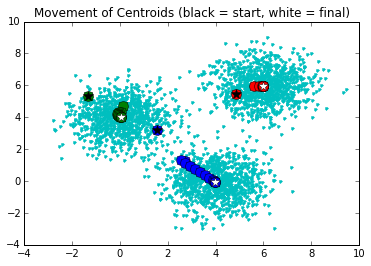


***FINISHED***


In [11]:
from mr_GMM_Init import GMM_Init
from mr_GMM_Iterate import GMM_Iterate
import json
from math import sqrt
import matplotlib.pyplot as plt

def plot_iteration(means):
    
    plt.plot(samples1[:, 0], samples1[:, 1], '.', color = 'c')
    plt.plot(samples2[:, 0], samples2[:, 1], '.', color = 'c')
    plt.plot(samples3[:, 0], samples3[:, 1],'.', color = 'c')
    
    for b,g,r in means:
        plt.plot(b[0], b[1],'o',markersize =10,color = 'b')
        
        plt.plot(g[0], g[1],'o',markersize =10,color = 'g')
        
        plt.plot(r[0], r[1],'o',markersize =10,color = 'r')
        
    b,g,r = means[-1]
    plt.plot(b[0], b[1],'*',markersize =10,color = 'w')
    plt.plot(g[0], g[1],'*',markersize =10,color = 'w')
    plt.plot(r[0], r[1],'*',markersize =10,color = 'w')

    b,g,r = means[0]
    plt.plot(b[0], b[1],'*',markersize =10,color = 'black')
    plt.plot(g[0], g[1],'*',markersize =10,color = 'black')
    plt.plot(r[0], r[1],'*',markersize =10,color = 'black')
    
    plt.title("Movement of Centroids (black = start, white = final)")
    
    plt.show()

def dist(x,y):
    #euclidean distance between two lists    
    sum = 0.0
    for i in range(len(x)):
        temp = x[i] - y[i]
        sum += temp * temp
    return sqrt(sum)

#first run the initializer to get starting centroids
filePath = 'data.txt'
myPathName = '/home/hduser/Notebooks/'
mrJobInit = GMM_Init(args=[filePath, '--pathName', myPathName, '--no-strict-protocol'])

with mrJobInit.make_runner() as runner:
    runner.run()

#pull out the centroid values to compare with values after one iteration
emPath = "intermediateResults.txt"
fileIn = open(emPath)
paramJson = fileIn.read()
fileIn.close()


delta = 10
iter_num = 0
centroids = []
#Begin iteration on change in centroids
while delta > 0.02:
    print "Iteration " + str(iter_num)
    iter_num = iter_num + 1
    #parse old centroid values
    oldParam = json.loads(paramJson)
    #run one iteration
    oldMeans = oldParam[1]
    mrJob2 = GMM_Iterate(args=[filePath,'--pathName', myPathName, '--no-strict-protocol'])
    with mrJob2.make_runner() as runner:
        runner.run()

    #compare new centroids to old ones
    fileIn = open(emPath)
    paramJson = fileIn.read()
    fileIn.close()
    newParam = json.loads(paramJson)

    k_means = len(newParam[1])
    newMeans = newParam[1]

    delta = 0.0
    for i in range(k_means):
        delta += dist(newMeans[i],oldMeans[i])
    #print oldMeans
    strOut = "delta={:>5.3f}".format(delta)
    for x,y in oldMeans:
        strOut = "{}\t[{:>7.4f},{:>7.4f}]".format(strOut, x, y)
    print strOut
    centroids.append(oldMeans)
    #plot_iteration(oldMeans)
    
    #plot_iteration(oldMeans)
print "Iteration" + str(iter_num)
strOut = "delta={:>5.3f}".format(delta)
for x,y in newMeans:
    strOut = "{}\t[{:>8.4f},{:>8.4f}]".format(strOut, x, y)
print strOut
centroids.append(newMeans)
plot_iteration(centroids)
print "\n***FINISHED***"